<a href="https://colab.research.google.com/github/adlisamir/ML_and_AI/blob/main/Burgers_1D_pytorch_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,30),
            nn.Tanh(),
            nn.Linear(30,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
'''
x_test = torch.arange(-1,1+0.1, 0.1)
#print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
#print(t_test)

X = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T
#print(X)

bc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T
#print(bc1_test)
#print(torch.meshgrid(x_test,t_test))

y_train_test = torch.tensor([1,2,3,4])
print(y_train_test)
y_train_test = y_train_test.unsqueeze(1)
print(y_train_test)
'''

'\nx_test = torch.arange(-1,1+0.1, 0.1)\n#print(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\n#print(t_test)\n\nX = torch.stack(torch.meshgrid(x_test,t_test)).reshape(2,-1).T\n#print(X)\n\nbc1_test = torch.stack(torch.meshgrid(x_test[-1],t_test)).reshape(2,-1).T\n#print(bc1_test)\n#print(torch.meshgrid(x_test,t_test))\n\ny_train_test = torch.tensor([1,2,3,4])\nprint(y_train_test)\ny_train_test = y_train_test.unsqueeze(1)\nprint(y_train_test)\n'

In [ ]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)

        # comp. domain
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T

        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic  = -torch.sin(math.pi * ic[:,0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        #print(du_dX)
        #print("xxxxxxxxxxxxxxxxxxxxxxxxx")
        #print(du_dX[0])

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]

        du_dxx = du_dXX[:,0]

        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/math.pi) * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
net = Net()
net.train()

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.13157299160957336
200 0.08695513010025024
300 0.06921936571598053
400 0.043032512068748474
500 0.02607319876551628
600 0.020287971943616867
700 0.01957339607179165
800 0.016451647505164146
900 0.015105299651622772
1000 0.014816733077168465
1100 0.010208211839199066
1200 1.0081920623779297
1300 0.004047769121825695
1400 0.0019593157339841127
1500 0.0013132712338119745
1600 0.000848034571390599
1700 0.000610342831350863
1800 0.0005069405888207257
1900 0.00042649381794035435
2000 0.00035156268859282136
2100 0.0003079427406191826
2200 0.00027806777507066727
2300 0.00024149671662598848
2400 0.000206926983082667
2500 0.0001778543955879286
2600 0.00015533281839452684
2700 0.0001409753895131871
2800 0.00013018015306442976
2900 0.00012318120570853353
3000 0.00011216894927201793
3100 9.885511826723814e-05
3200 9.120354661718011e-05
3300 7.946915866341442e-05
3400 7.112427556421608e-05
3500 6.626422691624612e-05
3600 6.13891170360148e-05
3700 5.8587764215189964e-05
3800 5.591502849711105e-0

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [ ]:
h = 0.01
k = 0.01

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [ ]:
X

tensor([[-1.0000,  0.0000],
        [-1.0000,  0.0100],
        [-1.0000,  0.0200],
        ...,
        [ 0.9900,  0.9700],
        [ 0.9900,  0.9800],
        [ 0.9900,  0.9900]], device='cuda:0')

In [ ]:
X.shape

torch.Size([20000, 2])

In [ ]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [ ]:
y_pred.shape

(200, 100)

In [ ]:
y_pred

array([[ 0.0027189 ,  0.00221885,  0.00181318, ..., -0.00134826,
        -0.00135659, -0.00136689],
       [ 0.03470675,  0.03325067,  0.03193588, ...,  0.00633992,
         0.00627532,  0.00620986],
       [ 0.06642873,  0.06403566,  0.06182776, ...,  0.01402441,
         0.01390292,  0.01378179],
       ...,
       [-0.09412024, -0.09152547, -0.08905701, ..., -0.02485984,
        -0.02468867, -0.02452522],
       [-0.06235898, -0.06071837, -0.0591499 , ..., -0.01701727,
        -0.01690378, -0.01679661],
       [-0.03037135, -0.02969832, -0.02904073, ..., -0.00916799,
        -0.00911128, -0.00906043]], dtype=float32)

In [ ]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

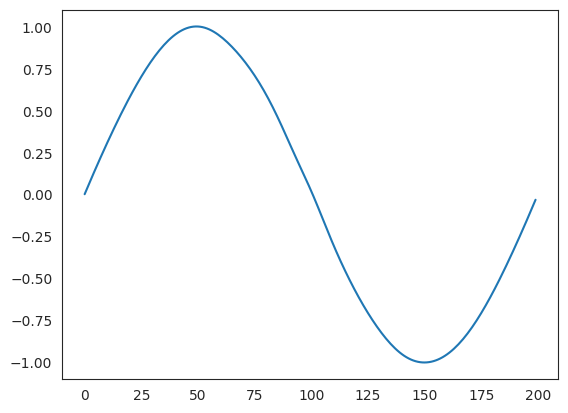

In [ ]:
plt.plot(y_pred[:,0])

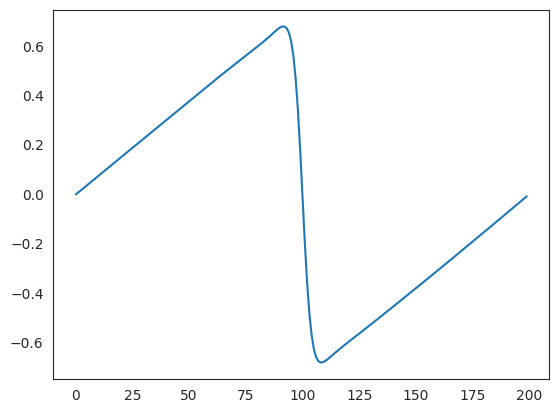

In [ ]:
plt.plot(y_pred[:,-1])

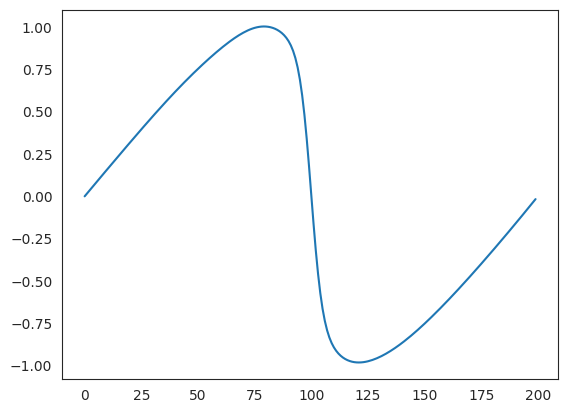

In [ ]:
plt.plot(y_pred[:,30])